In [1]:
import numpy as np


def read_bci_data():
    path = '/kaggle/input/hw2-eegnet/dataset'
    S4b_train = np.load(path+'/train/S4b_train.npz')
    X11b_train = np.load(path+'/train/X11b_train.npz')
    S4b_test = np.load(path+'/test/S4b_test.npz')
    X11b_test = np.load(path+'/test/X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label


In [2]:
train_data, train_label, test_data, test_label = read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [11]:
import torch
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, n_classes=2,alpha=1, drop=0.25):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(p=drop)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(p=drop)
        )
        self.classify = nn.Sequential(
            nn.Linear(736, n_classes)
        )

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x


In [4]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [39]:
import copy
import torch
import argparse
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader


class BCIDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        data = torch.tensor(self.data[index,...], dtype=torch.float32)
        label = torch.tensor(self.label[index], dtype=torch.int64)
        return data, label

    def __len__(self):
        return self.data.shape[0]

def plot_train_acc(train_acc_list, epochs):
    # TODO plot training accuracy
    epochs = list(range(epochs))
    plt.plot(epochs, train_acc_list)
    plt.ylabel('train acc')
    plt.xlabel('epoch')
    plt.title('train acc')
    plt.show()


def plot_train_loss(train_loss_list, epochs):
    # TODO plot training loss
    epochs = list(range(epochs))
    plt.plot(epochs, train_loss_list)
    plt.ylabel('train loss')
    plt.xlabel('epoch')
    plt.title('train loss')
    plt.show()

def plot_test_acc(test_acc_list, epochs):
    # TODO plot testing loss
    epochs = list(range(epochs))
    plt.plot(epochs, test_acc_list)
    plt.ylabel('test acc')
    plt.xlabel('epoch')
    plt.title('test acc')
    plt.show()

def train(model, loader, criterion, optimizer, args):
    best_acc = 0.0
    best_wts = None
    avg_acc_list = []
    test_acc_list = []
    avg_loss_list = []
    for epoch in range(1, args.num_epochs+1):
        model.train()
        with torch.set_grad_enabled(True):
            avg_acc = 0.0
            avg_loss = 0.0 
            for i, data in enumerate(loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                avg_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                avg_acc += pred.eq(labels).cpu().sum().item()

            avg_loss /= len(loader.dataset)
            avg_loss_list.append(avg_loss)
            avg_acc = (avg_acc / len(loader.dataset)) * 100
            avg_acc_list.append(avg_acc)
#             print(f'Epoch: {epoch}')
#             print(f'Loss: {avg_loss}')
#             print(f'Training Acc. (%): {avg_acc:3.2f}%')

        test_acc = test(model, test_loader)
        test_acc_list.append(test_acc)
        if test_acc > best_acc:
            best_acc = test_acc
            best_wts = model.state_dict()
        #print(f'Test Acc. (%): {test_acc:3.2f}%')

    #torch.save(best_wts, './weights/best.pt')
    print(f'Loss: {avg_loss}')
    print(f'Training Acc. (%): {avg_acc:3.2f}%')
    print(f'Test Acc. (%): {best_acc:3.2f}%')
    return avg_acc_list, avg_loss_list, test_acc_list


def test(model, loader):
    avg_acc = 0.0
    model.eval()
    with torch.set_grad_enabled(False):
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            for i in range(len(labels)):
                if int(pred[i]) == int(labels[i]):
                    avg_acc += 1

        avg_acc = (avg_acc / len(loader.dataset)) * 100

    return avg_acc


In [23]:
parser = argparse.ArgumentParser()
parser.add_argument("--num_epochs", type=int, default=250)
parser.add_argument("--batch_size", type=int, default=512)
parser.add_argument("--lr", type=float, default=0.01)
args = parser.parse_args(args=['--num_epochs', '150', '--batch_size', '64', '--lr', '0.001'])


In [7]:
args

Namespace(batch_size=64, lr=0.01, num_epochs=150)

In [24]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_data, train_label, test_data, test_label = read_bci_data()
train_dataset = BCIDataset(train_data, train_label)
test_dataset = BCIDataset(test_data, test_label)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

alphas = [1,0.7,0.5,0.3,0.2,0.1]
drops = [0.1, 0.25,0.5,0.65]
for drop in  drops:
    for alpha in alphas:
        print('alpha', alpha, 'drop', drop)
        model = EEGNet(alpha=alpha, drop=drop)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=0.001)

        model.to(device)
        criterion.to(device)

        train_acc_list, train_loss_list, test_acc_list = train(model, train_loader, criterion, optimizer, args)

        plot_train_acc(train_acc_list, args.num_epochs)
        plot_train_loss(train_loss_list, args.num_epochs)
        plot_test_acc(test_acc_list, args.num_epochs)

cuda
(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
alpha 1 drop 0.1
Loss: 0.0005028117982739652
Training Acc. (%): 99.72%
Test Acc. (%): 83.43%
alpha 0.7 drop 0.1
Loss: 0.000512216288458418
Training Acc. (%): 99.35%
Test Acc. (%): 82.13%
alpha 0.5 drop 0.1
Loss: 0.0006551456051292243
Training Acc. (%): 98.61%
Test Acc. (%): 83.15%
alpha 0.3 drop 0.1
Loss: 0.0006775326750896595
Training Acc. (%): 99.07%
Test Acc. (%): 85.19%
alpha 0.2 drop 0.1
Loss: 0.0007056021373029108
Training Acc. (%): 98.70%
Test Acc. (%): 82.50%
alpha 0.1 drop 0.1
Loss: 0.0004170691818688755
Training Acc. (%): 99.72%
Test Acc. (%): 82.59%
alpha 1 drop 0.25
Loss: 0.0015512001493738757
Training Acc. (%): 96.39%
Test Acc. (%): 83.70%
alpha 0.7 drop 0.25
Loss: 0.00135104240918601
Training Acc. (%): 97.78%
Test Acc. (%): 83.24%
alpha 0.5 drop 0.25
Loss: 0.0013860658501033429
Training Acc. (%): 96.85%
Test Acc. (%): 83.61%
alpha 0.3 drop 0.25
Loss: 0.0013706054917916103
Training Acc. (%): 97.31%
Test Acc. (%): 84.

# alpha 0.3 drop 0.25 is the best

In [46]:
model = EEGNet(alpha=0.3, drop=0.25)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=0.001)

model.to(device)
criterion.to(device)

train_acc_list, train_loss_list, test_acc_list = train(model, train_loader, criterion, optimizer, args)



Loss: 0.0019538317324110754
Training Acc. (%): 96.39%
Test Acc. (%): 81.11%


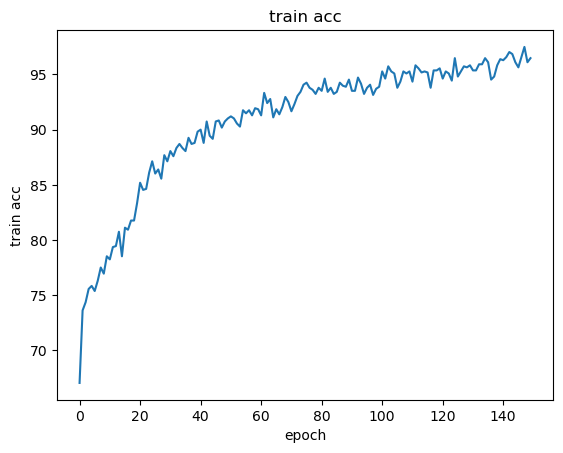

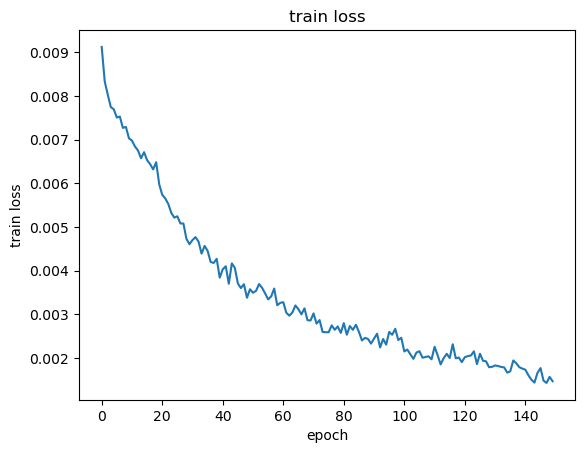

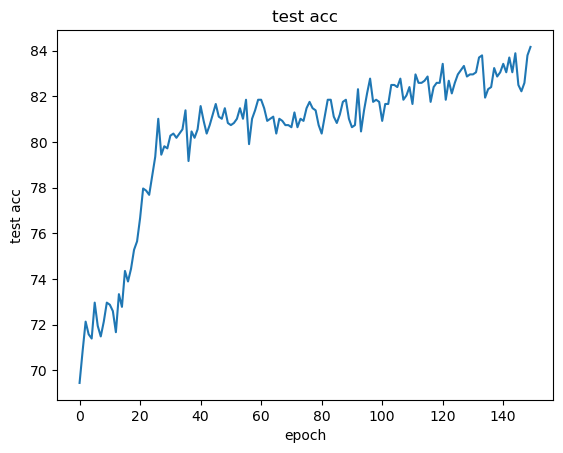

In [41]:
plot_train_acc(train_acc_list, args.num_epochs)
plot_train_loss(train_loss_list, args.num_epochs)
plot_test_acc(test_acc_list, args.num_epochs)